# **Recherche du meilleur modèle pour réaliser le clustering des clients**

*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1)*

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Pour normaliser et encoder les données
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Utilisés lors de l'ACP
from sklearn.decomposition import PCA

# Utilisé pour la t-SNE
from sklearn import manifold

from sklearn import cluster

from sklearn import metrics

# Utilisé pour savoir si le fichier excel d'export existe déjà
import os

## **Importation du dataset**

In [2]:
data = pd.read_excel("data_global.xlsx")

In [3]:
print('Toutes les variables :\n')
for i in data.columns:
    print(f"- {i} ({data[i].dtype})")

Toutes les variables :

- customer_unique_id (object)
- customer_lat (float64)
- customer_lng (float64)
- orders_number (int64)
- first_purchase_date (datetime64[ns])
- last_purchase_date (datetime64[ns])
- recency (int64)
- frequency (float64)
- avg_spent (float64)
- total_spent (float64)
- preferred_payment_type (object)
- avg_payment_installments (float64)
- shipping_fees_proportion (float64)
- avg_customer_seller_distance_km (float64)
- avg_delivery_time (float64)
- preferred_category (object)
- avg_review_score (float64)


## **Scaling des données**

- Choix des features

In [4]:
features_list = [
                 'customer_lat',
                 'customer_lng',
                 'orders_number',
                 'first_purchase_date',
                 'last_purchase_date',
                 'recency',
                 'frequency',
                 'avg_spent',
                 'total_spent',
                 'preferred_payment_type',
                 'avg_payment_installments',
                 'shipping_fees_proportion',
                 'avg_customer_seller_distance_km',
                 'avg_delivery_time',
                 'preferred_category',
                 'avg_review_score'
                ]

- Convertissons au préalable les variables dates *first_purchase_date* et *last_purchase_date* en Timestamps Unix, pour qu'elles soient traitées comme des valeurs numériques.

In [5]:
try:
    data['first_purchase_date'] = data['first_purchase_date'].apply(lambda x: x.timestamp()).astype(int)
    print("Format de 'first_purchase_date' modifié.")
except:
    print("'first_purchase_date' n'est pas présent dans les features ou a déjà été converti.")
try:
    data['last_purchase_date'] = data['last_purchase_date'].apply(lambda x: x.timestamp()).astype(int)
    print("Format de 'last_purchase_date' modifié.")
except:
    print("'last_purchase_date' n'est pas présent dans les features ou a déjà été converti.")

Format de 'first_purchase_date' modifié.
Format de 'last_purchase_date' modifié.


- Scaling des variables numériques, encoding des variables catégorielles

In [6]:
# Sélection des variables numériques
numeric_features = data[features_list].select_dtypes(include=['number']).columns.tolist()
# Sélection des variables catégorielles
categorical_features = data[features_list].select_dtypes(exclude=['number']).columns.tolist()

# Sélection des données
X = data.loc[:,features_list]

# Instanciation du sscaler
numeric_transformer = StandardScaler()
# Instanciation de l'encoder
categorical_transformer = OneHotEncoder(sparse_output=False)

feature_encoder = ColumnTransformer(
            transformers=[
                ('cat', categorical_transformer, categorical_features),    
                ('num', numeric_transformer, numeric_features)
                ]
            )
X = feature_encoder.fit_transform(X)


## **Réduction des dimentions de X pour pouvoir représenter les résultats en 2D : utilisation d'une t-SNE**

- Cette opération étant longue, le résultat est sauvegardé dans un fichier excel pour une réutilisation ultérieure plus rapide.

In [7]:
# Nom de fichier utilisé pour la sauvegarde
nom_fichier = 'X_tSNE'

# Si le fichier existe déjà : chargement des données
# Si le fichier n'existe pas : création des données par t-SNE et enregistrement dans le fichier
if os.path.isfile(f'{nom_fichier}.xlsx') == False:
    # Création des données par t-SNE
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=2000, init='pca', verbose=0, random_state=42)
    X_trans = tsne.fit_transform(X)
    # Enregistrement des données dans le fichier
    pd.DataFrame(X_trans).to_excel(f'{nom_fichier}.xlsx', index = False)
    print(f"Fichier {nom_fichier}.xlsx créé.")
    print("Données transformées stockées dans 'X_trans'")
else:
    print(f"Le fichier {nom_fichier}.xlsx existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")
    print(f"Importation des données depuis le fichier {nom_fichier}.xlsx...")
    # Chargement des données depuis le fichier excel
    X_trans = pd.read_excel(f"{nom_fichier}.xlsx").values
    print("Données importées et stockées dans 'X_trans'")

Le fichier X_tSNE.xlsx existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.
Importation des données depuis le fichier X_tSNE.xlsx...
Données importées et stockées dans 'X_trans'


## **Test des différents modèles**

- Fonction de représentation des clusters.

In [17]:
def draw_clusters(tsne_data=X_trans, modele=None, labels="Aucun"):
    """
    Cette fonction sert à représenter les différents clusters trouvés par un modèle sur des données en 2D.
    tsne_data (défaut : X_trans) : données projetées en 2D à utiliser, indispensable.
    modele (défaut : None) : nom du modèle utilisé.
    labels (défaut : "Aucun") : étiquettes de clusters à utiliser, indispensable.
    """
    if modele == None:
        modele = "modèle"
    if type(labels) == str:
        print("Vous devez indiquer les labels à utiliser.")
        return
        
    tsne_data = tsne_data
    plt.figure(figsize=(15, 15))
    sns.scatterplot(data=None, x=tsne_data[:, 0], y=tsne_data[:, 1], edgecolor='black', linewidth=0.5, alpha=0.75, s=75, hue=labels, palette="Set1")
    plt.title(f'\nReprésentation des {len(np.unique(labels))} clusters du {modele}\n sur les 2 composantes t-SNE\n', fontsize=25)
    plt.show()

### **1. KMeans**

- Création et entraînement du modèle.

In [9]:
clust_kmeans = cluster.KMeans(n_clusters=8, n_init='auto', algorithm='lloyd', max_iter=300, random_state=42)
clust_kmeans.fit(X)

KMeans(n_init='auto', random_state=42)

- Représentation des clusters sur les composantes de la t-SNE.

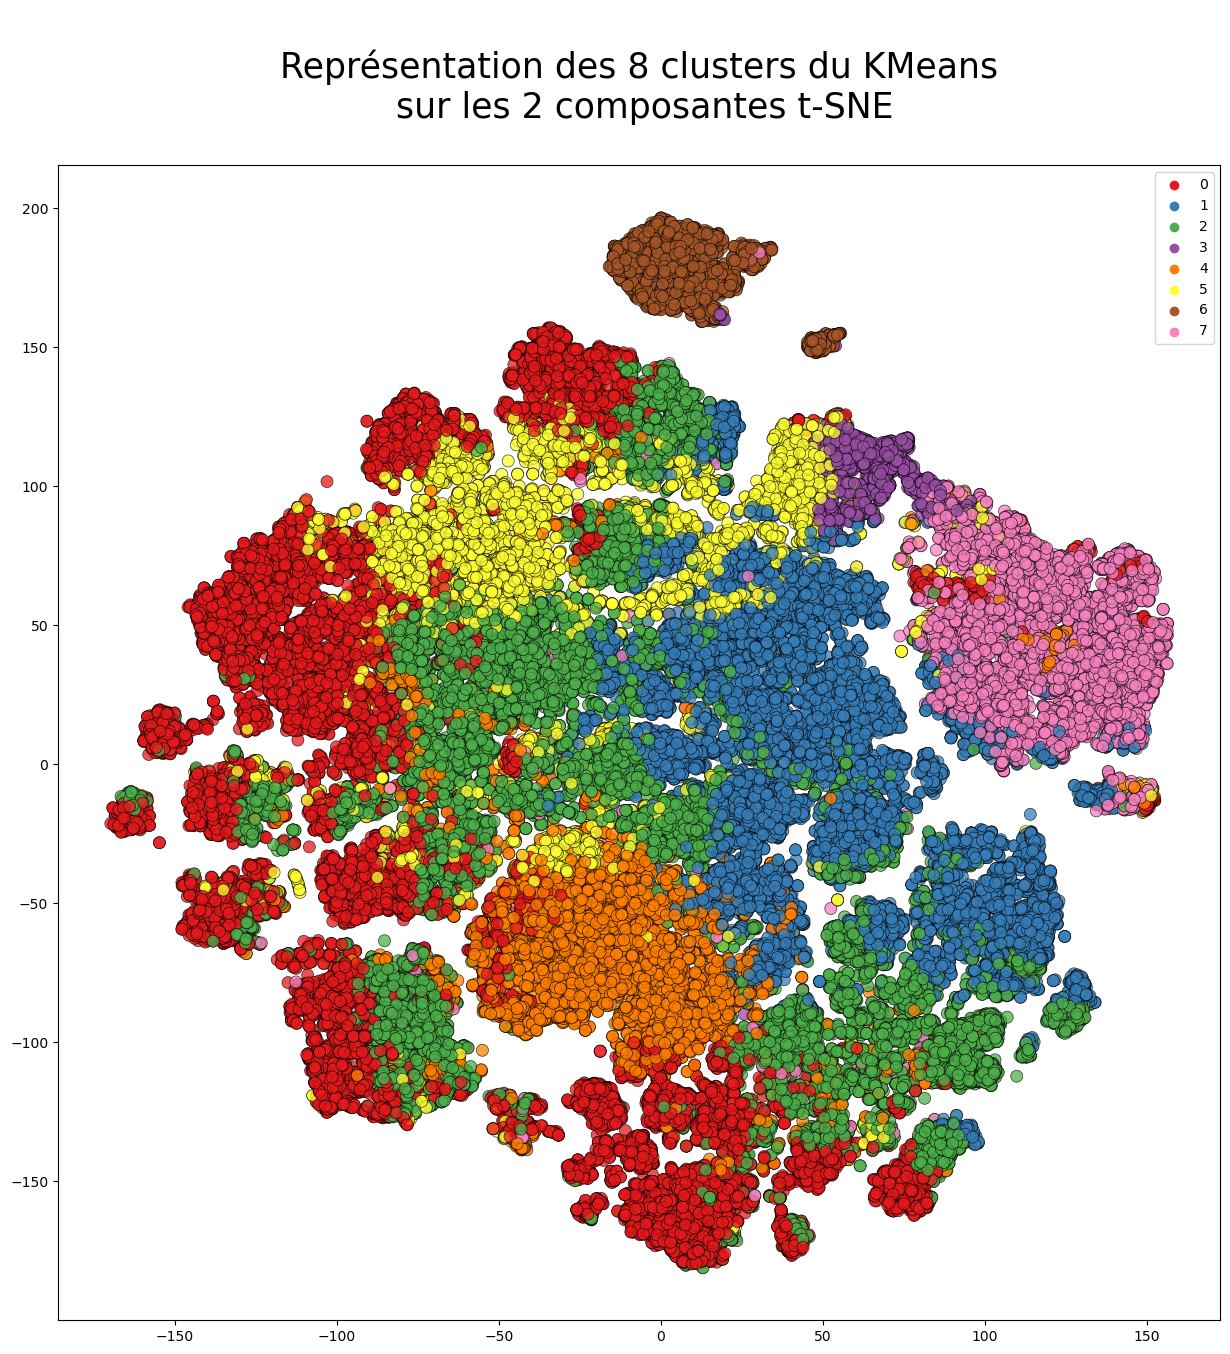

In [18]:
draw_clusters(modele='KMeans', labels=clust_kmeans.labels_)

- Calcul du coefficient de silhouette.

In [11]:
labels = clust_kmeans.labels_

print("Coefficient de silhouette : %0.3f"
      % metrics.silhouette_score(X, labels))

Coefficient de silhouette : 0.148
